<a href="https://colab.research.google.com/github/seelca/more-access/blob/main/MORE_ACCESS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

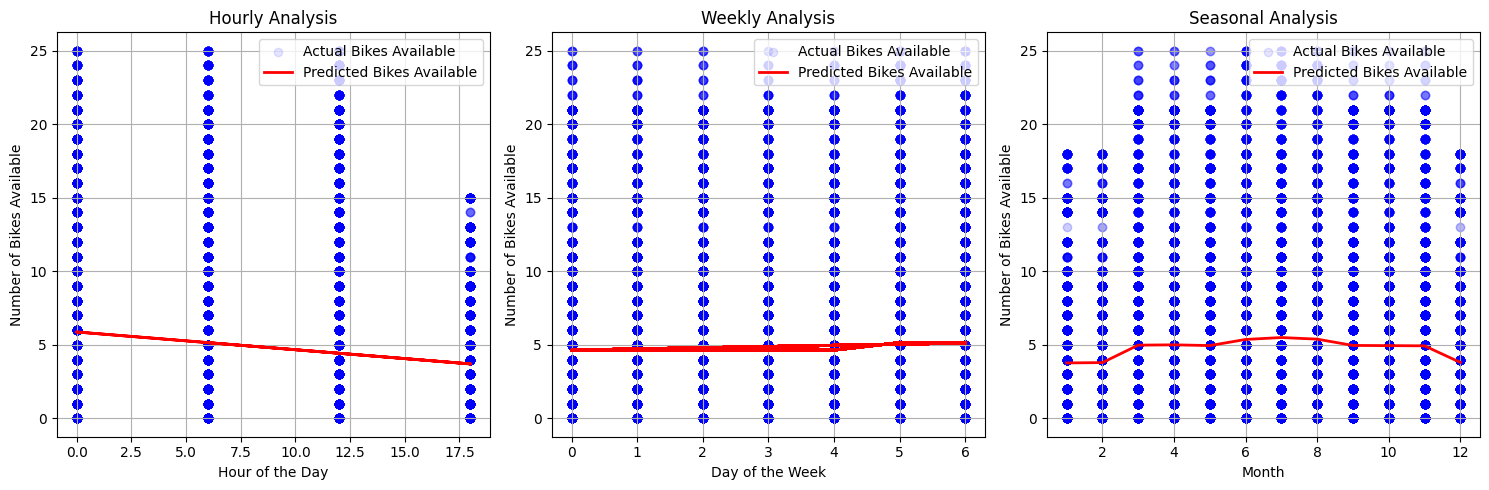

In [42]:
import pandas as pd
import folium
import requests
import random
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Function to fetch bike data from Nextbike API
def fetch_bike_data(city_uid=None, lat=None, lng=None, limit=100, distance=15000):
    base_url = "https://maps.nextbike.net/maps/nextbike-live.json"
    params = {"city": city_uid, "lat": lat, "lng": lng, "limit": limit, "distance": distance}
    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        return response.json()
    else:
        print("Failed to fetch data:", response.status_code)
        return None

# Fetching bike data for Milton Keynes
lat = 52.0406224
lng = -0.7594171
bike_data = fetch_bike_data(lat=lat, lng=lng)

# Class for Bike Stations
class BikeStation:
    def __init__(self, name, latitude, longitude, available_bikes):
        self.name = name
        self.latitude = latitude
        self.longitude = longitude
        self.available_bikes = available_bikes

    def add_to_map(self, map_object, timestamp):
        folium.Marker(
            location=[self.latitude, self.longitude],
            popup=f"{self.name}\nBikes Available: {self.available_bikes}\nTime: {timestamp}",
            icon=folium.Icon(color='blue')
        ).add_to(map_object)

# Extract and create BikeStation objects from the fetched data
bike_stations = []
for country in bike_data.get('countries', []):
    for city in country.get('cities', []):
        for place in city.get('places', []):
            if not place.get('bike', False):
                bike_stations.append(
                    BikeStation(
                        name=place.get('name'),
                        latitude=place.get('lat'),
                        longitude=place.get('lng'),
                        available_bikes=place.get('bikes')
                    )
                )

# Function to generate simulated bike data for different times of the day
def generate_simulated_bike_data(stations, start_time, end_time, interval_hours=6):
    data = []
    current_time = start_time

    while current_time <= end_time:
        for station in stations:
            # Simulate number of available bikes based on time of day
            hour = current_time.hour
            day_of_week = current_time.weekday()
            month = current_time.month

            # Time of day variation
            if 7 <= hour <= 9 or 17 <= hour <= 19:  # Commute hours (less availability)
                time_of_day_factor = 0.6
            else:  # Non-commute hours (more availability)
                time_of_day_factor = 1.2

            # Weekday/weekend variation
            if day_of_week >= 5:  # Weekend
                weekend_factor = 1.1
            else:
                weekend_factor = 0.9

            # Seasonal variation
            if month in [12, 1, 2]:  # Winter
                seasonal_factor = 0.7
            elif month in [6, 7, 8]:  # Summer
                seasonal_factor = 1.2
            else:
                seasonal_factor = 1.0

            bikes_available = int(station.available_bikes * time_of_day_factor * weekend_factor * seasonal_factor)
            bikes_available = max(0, min(bikes_available, station.available_bikes + random.randint(-5, 5)))

            data.append({
                'station_name': station.name,
                'latitude': station.latitude,
                'longitude': station.longitude,
                'timestamp': current_time,
                'bikes_available': bikes_available
            })

        current_time += timedelta(hours=interval_hours)

    return pd.DataFrame(data)

# Option to use simulated data or real-time data
use_simulated_data = True

if use_simulated_data:
    # Define the start and end times for the simulation
    start_time = datetime(2023, 1, 1, 6, 0, 0)
    end_time = datetime(2023, 12, 31, 22, 0, 0)
    # Generate the simulated bike data
    simulated_data = generate_simulated_bike_data(bike_stations, start_time, end_time)
    data_to_use = simulated_data
else:
    data_to_use = pd.DataFrame([{
        'station_name': station.name,
        'latitude': station.latitude,
        'longitude': station.longitude,
        'timestamp': datetime.now(),
        'bikes_available': station.available_bikes
    } for station in bike_stations])

# Perform linear regression analysis
data_to_use['hour'] = data_to_use['timestamp'].dt.hour
data_to_use['day_of_week'] = data_to_use['timestamp'].dt.weekday
data_to_use['month'] = data_to_use['timestamp'].dt.month

# Hourly Analysis
X_hour = data_to_use[['hour']]
y_hour = data_to_use['bikes_available']
model_hour = LinearRegression()
model_hour.fit(X_hour, y_hour)
data_to_use['predicted_bikes_hour'] = model_hour.predict(X_hour)

# Weekly Analysis
X_week = pd.get_dummies(data_to_use['day_of_week'], prefix='day')
model_week = LinearRegression()
model_week.fit(X_week, y_hour)
data_to_use['predicted_bikes_week'] = model_week.predict(X_week)

# Seasonal Analysis
X_season = pd.get_dummies(data_to_use['month'], prefix='month')
model_season = LinearRegression()
model_season.fit(X_season, y_hour)
data_to_use['predicted_bikes_season'] = model_season.predict(X_season)

# Visualization of the linear regression results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(data_to_use['hour'], data_to_use['bikes_available'], color='blue', alpha=0.1, label='Actual Bikes Available')
plt.plot(data_to_use['hour'], data_to_use['predicted_bikes_hour'], color='red', linewidth=2, label='Predicted Bikes Available')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Bikes Available')
plt.title('Hourly Analysis')
plt.legend(loc='upper right')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.scatter(data_to_use['day_of_week'], data_to_use['bikes_available'], color='blue', alpha=0.1, label='Actual Bikes Available')
plt.plot(data_to_use['day_of_week'], data_to_use['predicted_bikes_week'], color='red', linewidth=2, label='Predicted Bikes Available')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Bikes Available')
plt.title('Weekly Analysis')
plt.legend(loc='upper right')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.scatter(data_to_use['month'], data_to_use['bikes_available'], color='blue', alpha=0.1, label='Actual Bikes Available')
plt.plot(data_to_use['month'], data_to_use['predicted_bikes_season'], color='red', linewidth=2, label='Predicted Bikes Available')
plt.xlabel('Month')
plt.ylabel('Number of Bikes Available')
plt.title('Seasonal Analysis')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

# Create the base map
map = folium.Map(location=[52.04172, -0.75583], zoom_start=15)

# Create FeatureGroup for bike stations
bike_stations_layer = folium.FeatureGroup(name='Bike Stations')

# Add bike stations to the map with the timestamp from data_to_use
for index, row in data_to_use.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"{row['station_name']}\nBikes Available: {row['bikes_available']}\nTime: {row['timestamp']}",
        icon=folium.Icon(color='blue')
    ).add_to(bike_stations_layer)

# Add FeatureGroup to the map
bike_stations_layer.add_to(map)

# Add LayerControl to the map to allow layer switching
folium.LayerControl(collapsed=False).add_to(map)

# Display the map
# map
